In [1]:
import gym
from gym.envs.registration import register

# build a non-slippery environment
register(id='FrozenLake_NoSlip-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False} )

In [2]:
env = gym.make("FrozenLake_NoSlip-v0")
env_slippery = gym.make('FrozenLake-v0')

In [3]:
env.reset()

0

In [4]:
env.render()


SFFF
FHFH
FFFH
HFFG


In [5]:
action = 0
r = env.step(action)
print('stepped:', r)
env.render()

stepped: (0, 0.0, False, {'prob': 1.0})
  (Left)
SFFF
FHFH
FFFH
HFFG


In [6]:
print(env.action_space, env.action_space.n)  # the number of actions

Discrete(4) 4


In [7]:
print(env.observation_space, env.observation_space.n)  # the number of observations

Discrete(16) 16


In [8]:
state = env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


## State Transition Dynamics $P$

`P[state]` gives a dictionary of action dynamics:
`{action: [(probability, nextstate, reward, done)]}`

In [9]:
state = env.reset()
env.render()
print('state: ', state)

pa = env.P[state]
print(f'P[{state}]', pa)
print('action', '(p, next, rew, done):')
for k, v in pa.items():
    print(f'{k:5d}  {v}')


SFFF
FHFH
FFFH
HFFG
state:  0
P[0] {0: [(1.0, 0, 0.0, False)], 1: [(1.0, 4, 0.0, False)], 2: [(1.0, 1, 0.0, False)], 3: [(1.0, 0, 0.0, False)]}
action (p, next, rew, done):
    0  [(1.0, 0, 0.0, False)]
    1  [(1.0, 4, 0.0, False)]
    2  [(1.0, 1, 0.0, False)]
    3  [(1.0, 0, 0.0, False)]


In [10]:
# The slippery case has stochastic state-transition dynamics
state = 0  # starting location
pa = env_slippery.P[state]
print(f'P[{state}]')
print('action', '(p, next, rew, done):')
for k, v in pa.items():
    print(f'{k:5d}  {v}')

P[0]
action (p, next, rew, done):
    0  [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False)]
    1  [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False)]
    2  [(0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)]
    3  [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False)]


## Let's see what happens with the environment.

In [11]:
state = env.reset()

nsteps = 0
G = 0  # total return

frames = [] # for animation, see next cell

done = False

while not done:
    action = env.action_space.sample()              # randome action choice
    state, reward, done, info = env.step(action)    # apply action

    G += reward
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'action': action,
        'state': state,
        'reward': reward
        }
    )

    nsteps += 1
#
print(f'Last reward: {reward}\nTotal Steps: {nsteps}\nTotal Return: {G}')

Last reward: 0.0
Total Steps: 4
Total Return: 0.0


In [12]:
len(frames)

4

In [13]:
frames

[{'frame': '  (Right)\nS\x1bF\x1bFF\nFHFH\nFFFH\nHFFG\n',
  'action': 2,
  'state': 1,
  'reward': 0.0},
 {'frame': '  (Left)\n\x1bS\x1bFFF\nFHFH\nFFFH\nHFFG\n',
  'action': 0,
  'state': 0,
  'reward': 0.0},
 {'frame': '  (Right)\nS\x1bF\x1bFF\nFHFH\nFFFH\nHFFG\n',
  'action': 2,
  'state': 1,
  'reward': 0.0},
 {'frame': '  (Down)\nSFFF\nF\x1bH\x1bFH\nFFFH\nHFFG\n',
  'action': 1,
  'state': 5,
  'reward': 0.0}]

### Two Rendering Modes

In [14]:
env.render(mode='human')

  (Down)
SFFF
FHFH
FFFH
HFFG


In [15]:
env.render()

  (Down)
SFFF
FHFH
FFFH
HFFG


In [16]:
env.render(mode='ansi')

'  (Down)\nSFFF\nF\x1bH\x1bFH\nFFFH\nHFFG\n'

Use `print()` to get proper visual display of the output.

In [17]:
print(frames[0]['frame'])

  (Right)
SFFF
FHFH
FFFH
HFFG



In [18]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames, repeat=1, pause=.4):
    while repeat > 0:
        G = 0
        for i, frame in enumerate(frames):
            G += frame['reward']
            clear_output(wait=True)
            print(frame['frame'])
            print(f"Timestep: {i + 1}")
            print(f"Action: {frame['action']}")
            print(f"State: {frame['state']}")
            print(f"Reward: {frame['reward']}  {G}")
            sleep(pause)
        repeat -= 1
    sleep(pause)
#     

In [19]:
print_frames(frames, pause=.5, repeat=4)

  (Down)
SFFF
FHFH
FFFH
HFFG

Timestep: 4
Action: 1
State: 5
Reward: 0.0  0.0


## Q-Learning
- Update action-value function $Q(s,a)$ step by step on-line.

$$
    Q(s, a) = (1-\alpha) Q(s, a) + \alpha\big(r + \gamma \max_{a'} Q(s', a') \big)
$$

Algorithm:

1. Initialize Q
1. Choose an action A.
1. Apply action A. From current state S, travel to the next state S'. Observer reward R.
1. Update Q-table
1. Repeat

Assumption:
- The observation from the environment is equivalent to state S.

In [20]:
# How many states do we have?
n_states = env.observation_space.n  # == len(env.P)  
n_actions = env.action_space.n 
print('n_states: ', n_states)
print('n_actions: ', n_actions)

n_states:  16
n_actions:  4


In [21]:
import numpy as np 

# 1. initialize Q table
Q = np.ones((n_states, n_actions), dtype=float)

### Learning Iteration

In [22]:
# %%time 
# training the agent (Q table)

from IPython.display import clear_output 

# hyper parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1 

n_iters = 100000
rng = np.random.default_rng(2021)
Glist, nstepsList = [], []
maxG = -100
for iter in range(n_iters):

    # start a new episode -------------------
    state = env.reset()
    done = False
    G, nsteps = 0, 0
    while not done:  # repeat until the terminal or too many wondering steps
        # 1. choose Action
        # we employ e-greedy policy
        if rng.uniform() < epsilon:  # random exploration
            action = rng.integers(low=0, high=n_actions)
        else:                    # greedy action
            action = np.argmax(Q[state])  # Q[s] gives an array of action values of size n_actions
        #
        # 2. Move
        obs, reward, done, info = env.step(action)

        # 3. Update
        q_next = Q[obs]
        max_q = np.max(q_next)

        Q[state, action] = (1 - alpha) * Q[state, action] \
                               + alpha * ( reward + gamma * max_q )
        #
        # 4. step forward
        state = obs 
        nsteps += 1 
        G += reward 
    # end of episode -----------------------
    Glist.append(G)
    nstepsList.append(nsteps)
    if maxG < G:
        maxG = G
    if iter % 100 == 0:
        clear_output(wait=True)
        print(f'Episode: {iter}, G: {G} {nsteps}, maxG: {maxG}')
# end of learning
print('Finished.')

Episode: 99900, G: 1.0 6, maxG: 1.0
Finished.


Let's check the Q table learned.

In [23]:
state = env.reset()
env.render()
Q[state]


SFFF
FHFH
FFFH
HFFG


array([1.0097379, 1.121931 , 1.121931 , 1.0097379])

In [24]:
env.render()


SFFF
FHFH
FFFH
HFFG


Let's test the learning by following $A = arg\max_a Q[S, a]$ at every state $S$.

In [25]:
def greedy_action(qtable, S):
    q = qtable[S]
    a = np.argmax(q)
    return a 

def run(env, verbose=True):
    state = env.reset()

    steps = 0
    G = 0  # total return

    frames = [] # for animation, see next cell
    done = False

    while not done:
        action = greedy_action(Q, state)              # randome action choice
        state, reward, done, info = env.step(action)    # apply action

        G += reward
    
        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )

        steps += 1
    #
    if verbose:
        print(f'Last reward: {reward}\nTotal Steps: {steps}\nTotal Return: {G}')
    #
    return G, steps, frames
#

In [26]:
G, steps, frames = run(env)

Last reward: 1.0
Total Steps: 6
Total Return: 1.0


In [27]:
print_frames(frames, repeat=10)

  (Right)
SFFF
FHFH
FFFH
HFFG

Timestep: 6
Action: 2
State: 15
Reward: 1.0  1.0


In [28]:
# let's try another game

g, steps, frames = run(env)
print_frames(frames, repeat=5)

  (Right)
SFFF
FHFH
FFFH
HFFG

Timestep: 6
Action: 2
State: 15
Reward: 1.0  1.0


### Learning Curves

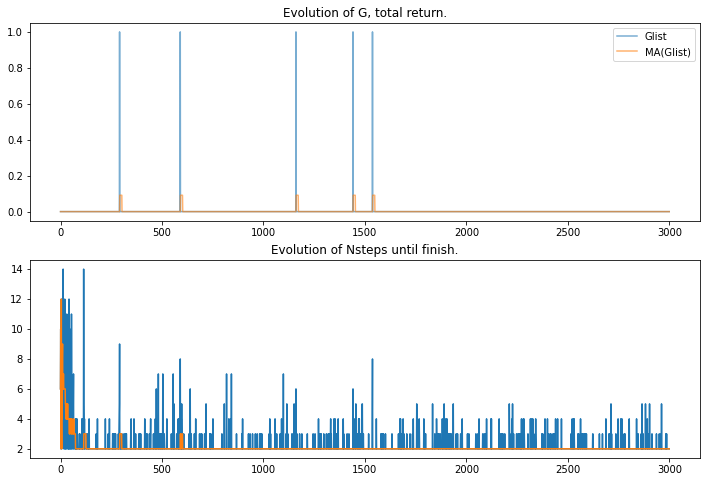

In [29]:
import matplotlib.pyplot as plt 

def moving_average(arr, tab=11):
    a = np.array(arr)
    ma = a.copy()
    for i in range(tab, len(arr)):
        ma[i] = a[i-tab:i].mean()
    return ma 

fig, axes = plt.subplots(2,1, figsize=(12,8))
n = 3000
axes[0].plot(Glist[:n], label='Glist', alpha=.6); axes[0].set(title='Evolution of G, total return.')
axes[0].plot(moving_average(Glist[:n]), alpha=.6, label='MA(Glist)'); axes[0].legend()
axes[1].plot(nstepsList[:n]); axes[1].set(title='Evolution of Nsteps until finish.');
axes[1].plot(moving_average(nstepsList[:n]));

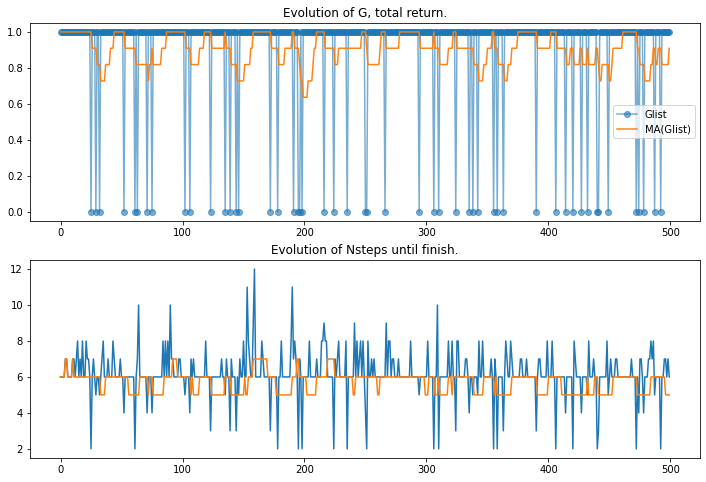

In [30]:
# Learning curve at the last stage.

fig, axes = plt.subplots(2,1, figsize=(12,8))
n = -500
axes[0].plot(Glist[n:], '-o', label='Glist', alpha=.6); axes[0].set(title='Evolution of G, total return.')
axes[0].plot(moving_average(Glist[n:]), alpha=.96, label='MA(Glist)'); axes[0].legend()
axes[1].plot(nstepsList[n:]); axes[1].set(title='Evolution of Nsteps until finish.');
axes[1].plot(moving_average(nstepsList[n:]));

- The failure cases during the learning episodes are due to Exploration.
- After learning, the greedy policy results in the optimal policy; it is shown below.

### Evaluation of the learned agent's performance

- Total return is always 1.
- Finishes the job in the minimal number of steps.

In [31]:
nrepeat = 240

glist, nslist = [], []
for _ in range(nrepeat):
    g, ns, _ = run(env, verbose=False)
    glist.append(g)
    nslist.append(ns)

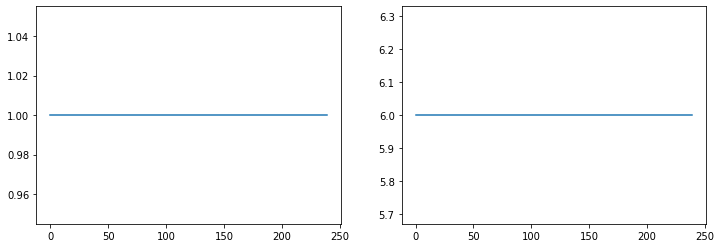

In [32]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].plot(glist);
axes[1].plot(nslist);

About the hyper-parameters

- The learning rate $\alpha$ should decrease as you continue to gain a larger and larger knowledge base.
- The exploration parameter $\epsilon$ should decrease since it is needed less and less as we learn since the policy is good enough after learning.
- Assumption is that the environment is stationary - not changing at all through time. But if it is slowly changing, we need to keep $\alpha$ and $\epsilon$ at some reasonalbe values.

Pros and Cons.

Pros

- Well it works.

Cons

- If the number of states and actions are large, it will difficult to finish learing quickly, and it may be difficult to keep the table in main memory space.

## Where to go

- Look at the slippery case.

- Apply to other gym environments having discrete spaces.

- Apply discretization to `Mountain Car` problem to use the ready-made q-learning code. The state space of Mountain Car enviroment has continuous values (real numbers).


- You may try NN instead of table. Before delving into more interesting and complicated problems, it will give you some experience about using NN in RL.


## References

1. https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/
1. https://www.coursera.org/learn/practical-rl?ranMID=40328&ranEAID=OyHlmBp2G0c&ranSiteID=OyHlmBp2G0c-Vmlv9yIsBFjTZ9sHpM8lbQ&siteID=OyHlmBp2G0c-Vmlv9yIsBFjTZ9sHpM8lbQ&utm_content=10&utm_medium=partners&utm_source=linkshare&utm_campaign=OyHlmBp2G0c